In [9]:
import re
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import timedelta
from collections import defaultdict

In [10]:
def to_seconds(s):
    hh, mm, ss = re.match(r'(\d{2}):(\d{2}):(\d{2})', s).groups()
    return timedelta(hours=int(hh), minutes=int(mm), seconds=int(ss)).seconds

def to_gb(mb):
    return round(float(mb) / 1000, 2)

def to_rate(i):
    return round(float(i), 2)

In [11]:
RESULTS_FOLDER = Path('../results')

# 1. Point-point experiments

In [12]:
def read_results_file(file):
    with open(file) as f:
        data = {k.strip(): v.strip() for k, v in (l.split('|') for l in f)}
    
    data['index_size'] = to_gb(data['index_size'].split(' ', 1)[0])
    data['build_time'] = to_seconds(data['build_time'].split(' ', 1)[0])
    data['dquery_throughput'] = [to_rate(x) for x in data['dquery_throughput'].split(']', 1)[0].strip('[').split(', ')]
    data['rquery_throughput'] = [to_rate(x) for x in data['rquery_throughput'].split(']', 1)[0].strip('[').split(', ')]
    return data

In [13]:
def get_experiment_results(results_folder, name):
    IDXS = ['geos_strtree', 'geos_quadtree', 's2_pointindex']
    IDX_SIZES = ['0_25m', '2_5m', '25m', '250m']

    results = defaultdict(lambda: defaultdict(list))

    for idx in IDXS:
        for size in IDX_SIZES:
            data = read_results_file(results_folder / f'{idx}_{name}-{size}.txt')
            results['index_size'][idx].append(data['index_size'])
            results['build_time'][idx].append(data['build_time'])

            if size != '250m':
                results['dquery_throughput_a'][idx].extend(data['dquery_throughput'])
                results['rquery_throughput_a'][idx].extend(data['rquery_throughput'])
            else:
                results['dquery_throughput_a'][idx].append(data['dquery_throughput'][-2])
                results['rquery_throughput_a'][idx].append(data['rquery_throughput'][-2])
                results['dquery_throughput_b'][idx].extend(data['dquery_throughput'])
                results['rquery_throughput_b'][idx].extend(data['rquery_throughput'])
    
    return results

## 1.1 nyc-taxi baseline

In [14]:
def plot(ax, results, labels, metric):
    X = labels[metric]['x']

    ax.plot(X, results[metric]['geos_strtree'], marker='s', label='strtree')
    ax.plot(X, results[metric]['geos_quadtree'], marker='^', label='quadtree')
    ax.plot(X, results[metric]['s2_pointindex'], marker='v', label='s2pointindex')

    ax.set_title(labels[metric]['title'])
    ax.set_xticks(X, labels[metric]['xticks'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(labels[metric]['xlabel'])
    ax.set_ylabel(labels[metric]['ylabel'])
    ax.legend()

In [15]:
labels = {
    'index_size': {
        'title': 'Index Size',
        'ylabel': 'Memory (GB)',
        'xlabel': '#Points',
        'x': [250_000, 2_500_000, 25_000_000, 250_000_000],
        'xticks': ['0.25m', '2.5m', '25m', '250m'],
    },
    'build_time': {
        'title': 'Build Time',
        'ylabel': 'Build time (s)',
        'xlabel': '#Points',
        'x': [250_000, 2_500_000, 25_000_000, 250_000_000],
        'xticks': ['0.25m', '2.5m', '25m', '250m']
    },
    'dquery_throughput_a': {
        'title': 'Distance query throughput',
        'ylabel': 'Throughput (queries/s)',
        'xlabel': '#Points',
        'x': [250_000, 2_500_000, 25_000_000, 250_000_000],
        'xticks': ['0.25m', '2.5m', '25m', '250m']
    },
    'dquery_throughput_b': {
        'title': 'Distance query throughput',
        'ylabel': 'Throughput (queries/s)',
        'xlabel': 'Selectivity',
        'x': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'xticks': ['0.0001', '0.001', '0.01', '0.1', '1.0']
    },
    'rquery_throughput_a': {
        'title': 'Range query throughput',
        'ylabel': 'Throughput (queries/s)',
        'xlabel': '#Points',
        'x': [250_000, 2_500_000, 25_000_000, 250_000_000],
        'xticks': ['0.25m', '2.5m', '25m', '250m']
    },
    'rquery_throughput_b': {
        'title': 'Range query throughput',
        'ylabel': 'Throughput (queries/s)',
        'xlabel': 'Selectivity',
        'x': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'xticks': ['0.0001', '0.001', '0.01', '0.1', '1.0']
    },
}

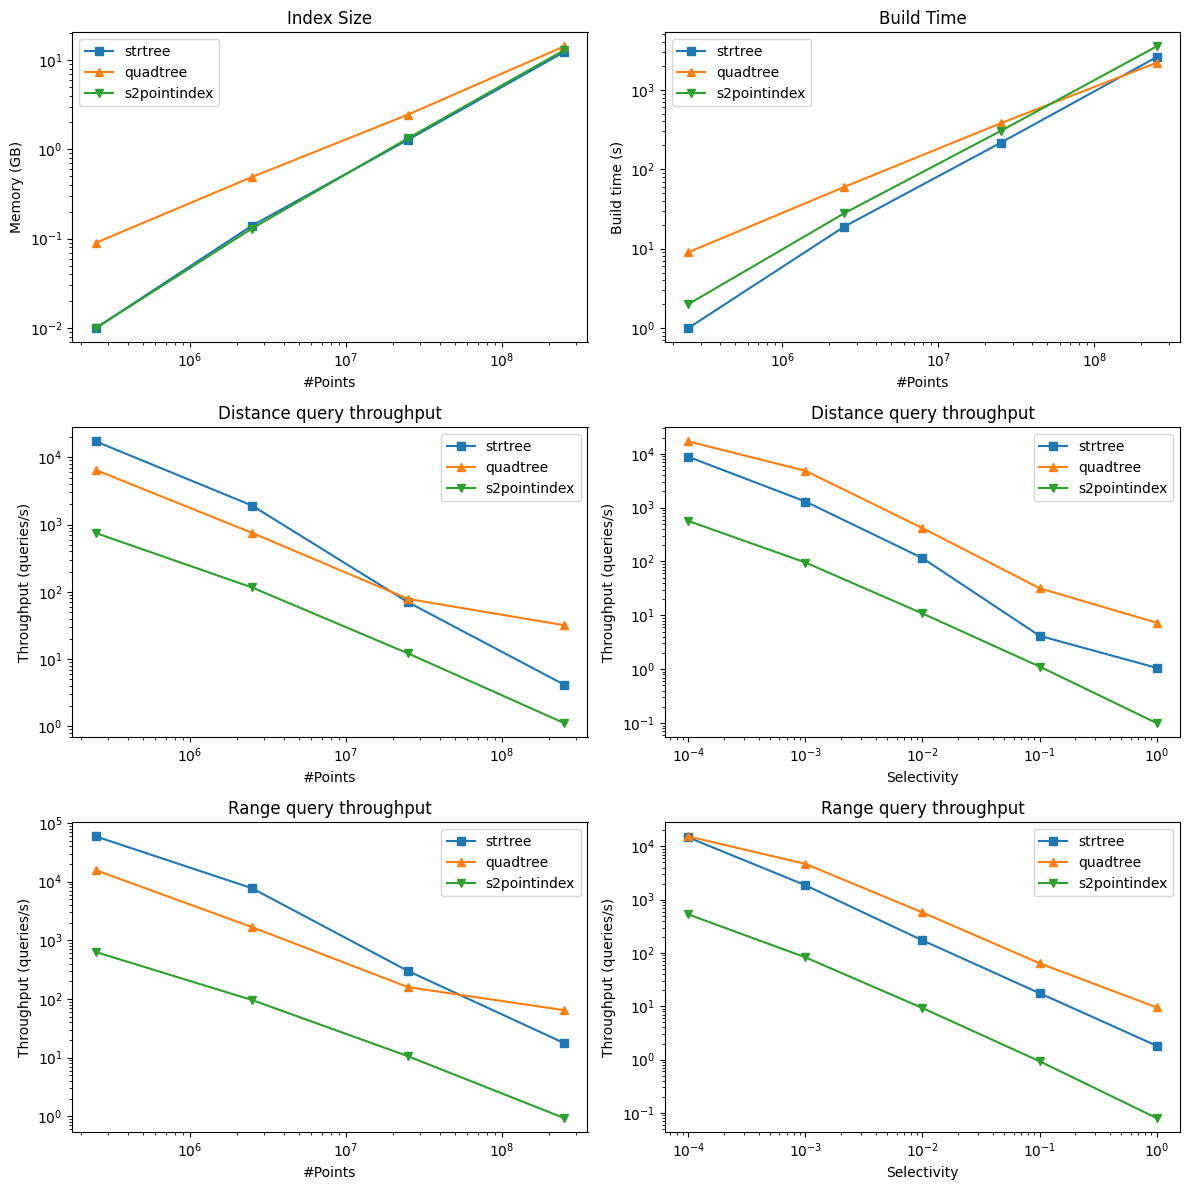

In [16]:
results_nyctaxi = get_experiment_results(RESULTS_FOLDER / 'run01', 'nyc-taxi')

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for ax, metric in zip(axs.flat, ['index_size', 'build_time', 'dquery_throughput_a', 'dquery_throughput_b', 'rquery_throughput_a', 'rquery_throughput_b']):
    plot(ax, results_nyctaxi, labels, metric)

fig.tight_layout()

## 1.2 Baseline comparisons

In [17]:
def plot_exps(ax, results, labels, metric, idx):
    X = labels[metric]['x']

    for exp, marker in zip(results.keys(), ['s', '1', '2', '3', '4']):
        ax.plot(X, results[exp][metric][idx], marker=marker, label=exp, linewidth=1)

    ax.set_title(f"{labels[metric]['title']} - {idx}")
    ax.set_xticks(X, labels[metric]['xticks'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(labels[metric]['xlabel'])
    ax.set_ylabel(labels[metric]['ylabel'])
    ax.legend()

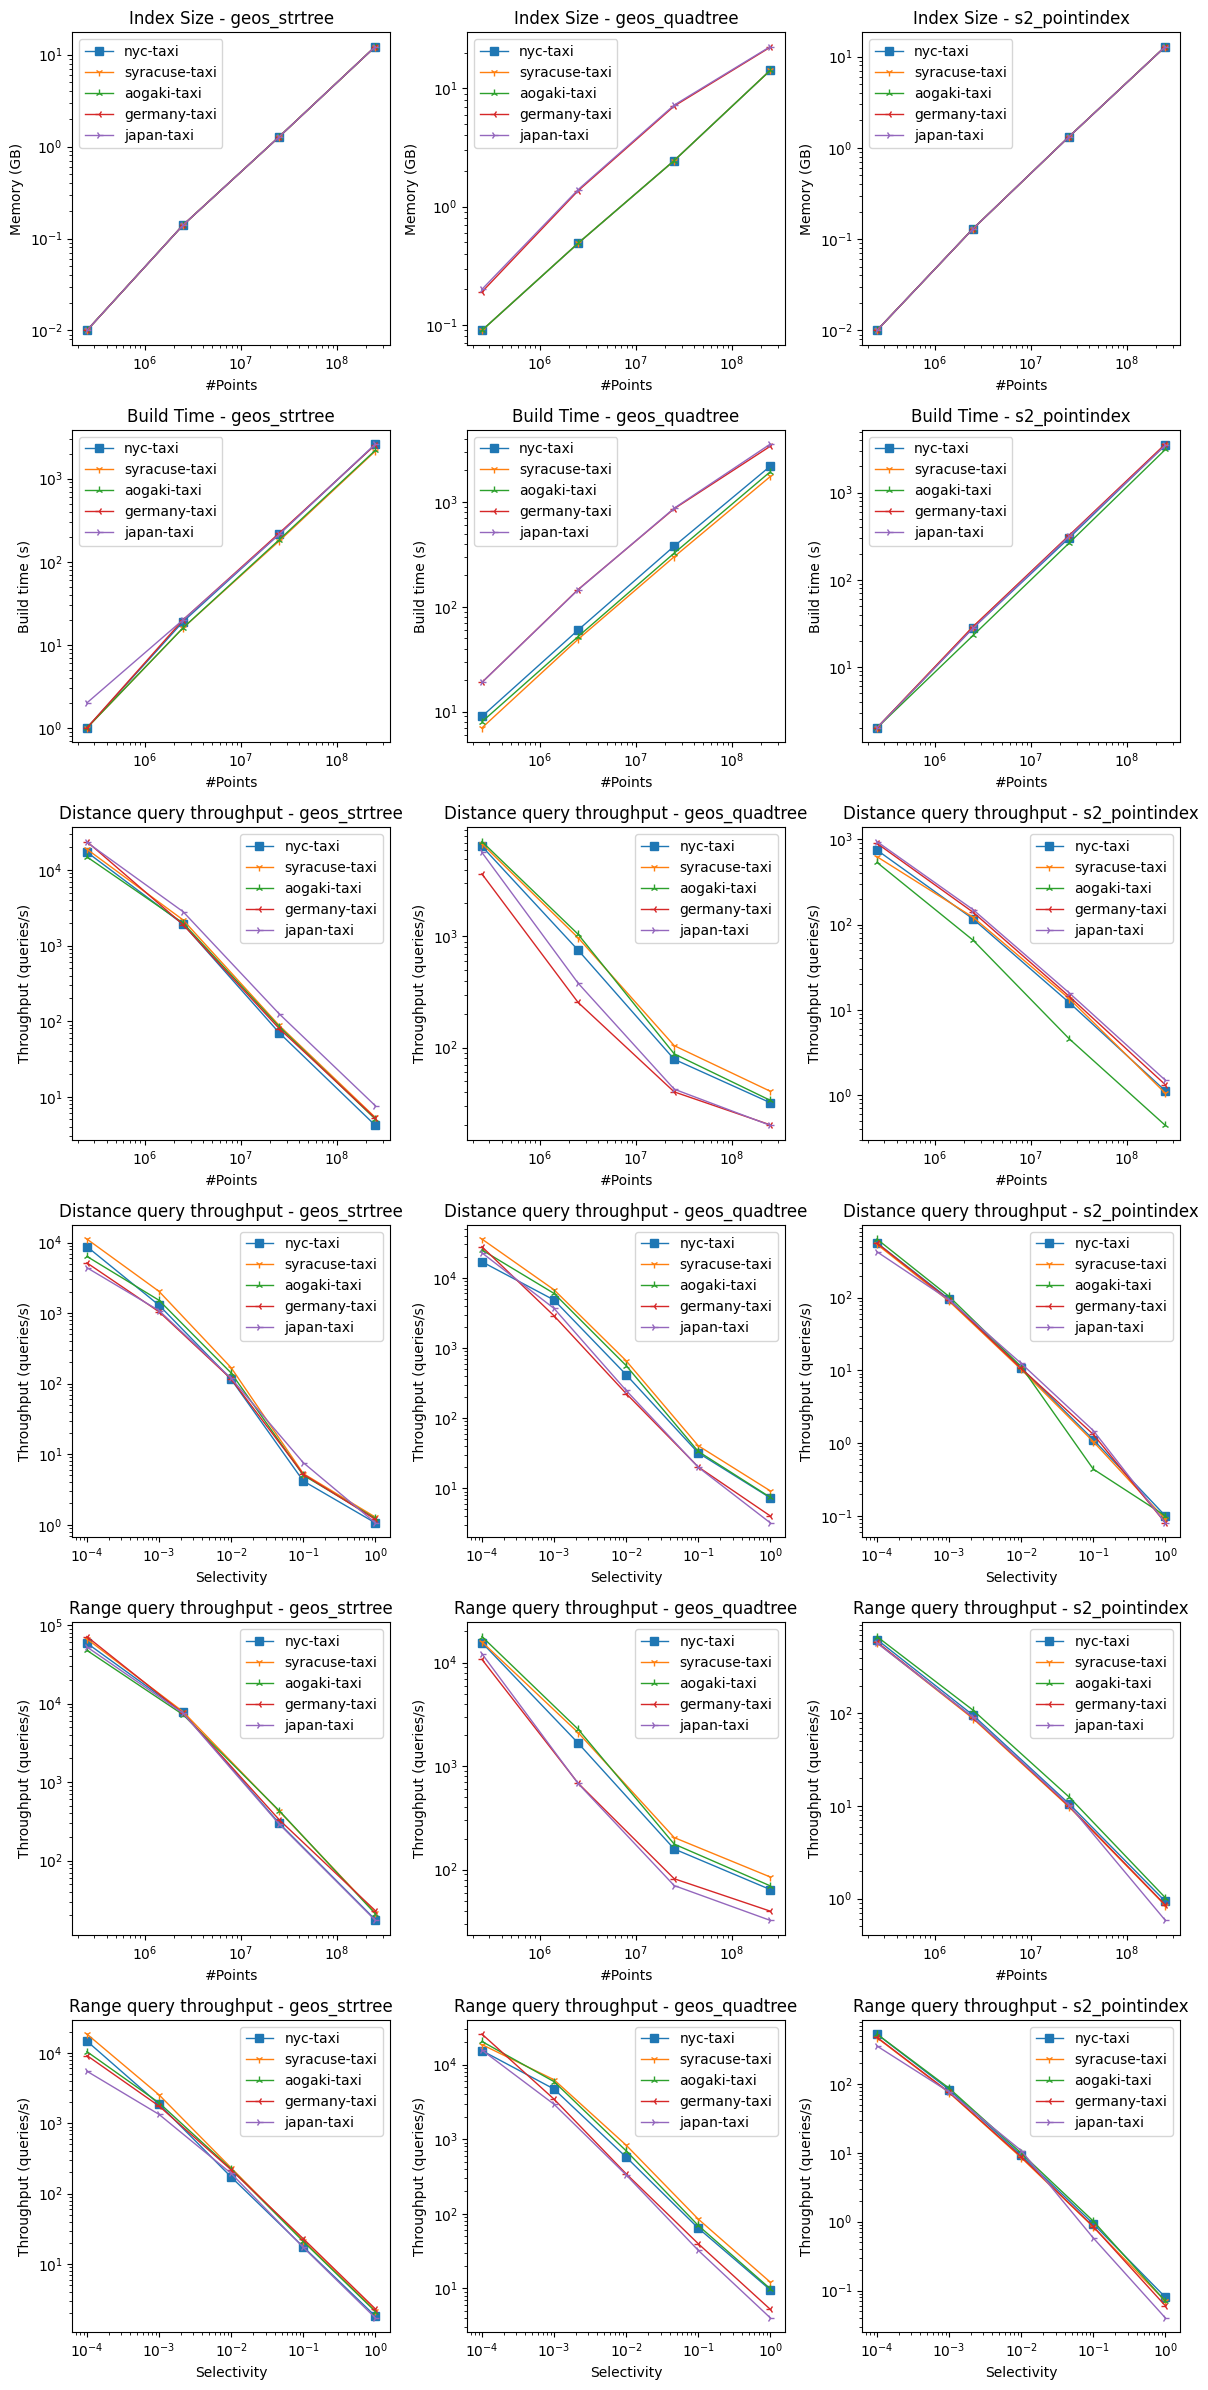

In [18]:
exp_results = {
    exp: get_experiment_results(RESULTS_FOLDER / 'run01', exp) 
    for exp in ['nyc-taxi', 'syracuse-taxi', 'aogaki-taxi', 'germany-taxi', 'japan-taxi']
}

fig, axs = plt.subplots(6, 3, figsize=(12, 24))

for row, metric in zip(axs, ['index_size', 'build_time', 'dquery_throughput_a', 'dquery_throughput_b', 'rquery_throughput_a', 'rquery_throughput_b']):
    for ax, idx in zip(row, ['geos_strtree', 'geos_quadtree', 's2_pointindex']):
        plot_exps(ax, exp_results, labels, metric, idx)


fig.tight_layout()

# Next steps

- Uniform square dataset around Aogaki: optimal for quadtree, suboptimal for S2 pointindex
- Uniform line dataset: suboptimal for quadstree, strstree